In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from keras import layers
from keras import models
from keras.models import Model
import numpy as np
import random
from skimage.color import rgb2gray
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from PIL import Image
from keras.preprocessing import image
from sklearn.cluster import KMeans
import csv
import math
import pandas as pd
import itertools

import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

# total number of images available in the airbus ship dataset
total_images = 192556

Using TensorFlow backend.


In [248]:
# train_ship_segmentations is a csv with two columns: imageId, EncodedPixels
# each row is a mask for 1 ship, so there may be multiple imageIds for images
# with multiple ships. If an image has no ship, EncodedPixels is NaN.
ship_masks = 'airbus-ship-detection\\train_ship_segmentations_v2.csv'
masks = pd.read_csv(ship_masks)

def runLengthDecode(mask_rle, shape=(768, 768)):
    """
    This function will take a single encoding for a ship and 
    turn it into a mask (i.e. one value of "EncodedPixels")
    
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array:
        0 - background
        1 - mask

    """
    # split on spaces
    s = mask_rle.split()
    # get the start and length of each: start, length, start, length, start, length, etc.
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    # get the ends of all the starts
    ends = starts + lengths
    # create array of zeros
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    # for each length change to one
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    # reshape and return
    return img.reshape(shape).T

def getImageMask(imgId):
    """
    Gets all masks for the given Image ID.
    Each ship gets its own mask, so there are
    multiple masks for images with multiple ships.
    
    imgId (str): image name to get the mask of (e.g. "00asb3s30.jpg")
    
    """
    img_masks = masks.loc[masks['ImageId'] == imgId, 'EncodedPixels']
    # get rid of nulls for when the image does not contain any ships
    img_masks.dropna(inplace=True)
    img_masks.tolist()
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768))
    for mask in img_masks:
        all_masks += runLengthDecode(mask)
    #invert image to allow for a more accurate loss
    all_masks[all_masks == 0] = 2
    all_masks[all_masks != 2] = 0
    all_masks[all_masks != 0] = 1
    return all_masks

In [ ]:
# this generates jpg of the image masks, intended to only run once
dir_ = 'airbus-ship-detection\\labels_\\'

for id in masks['ImageId']:
    out_file = dir_+id
    im = Image.fromarray(getImageMask(id).astype(np.uint8))
    im.save(out_file, format='JPEG')

In [2]:
def img2array(img_path):
    """
    reads in an image path and loads the image as an
    array with pixel value from 0 to 1
    
    """
    img = image.load_img(img_path, target_size=(256, 256))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    np.expand_dims(img_tensor, axis=0)
    img_tensor
    return img_tensor/255

In [3]:
def makeData(batch_size):
    """
    Gets a randomly seeded set of consecutive images
    within the dataset for a given batch_size.
    
    """
    data = []
    labels = []
    count = 0
    root = 'airbus-ship-detection\\'
    d1 = 'train_v2\\'
    d2 = 'labels_\\'
    
    # get random seed to choose a batch of consecutive images
    seed = int(np.random.random(1)*((total_images-1) - batch_size)) - 1
    
    f = csv.reader(open(root+'train_ship_segmentations_v2.csv'))
    
    for row in itertools.islice(f, seed, seed + batch_size):
        # read in data image as an array and append to data for batch
        data = np.append(data, [np.array(img2array(root + d1 + row[0]))])
        # read in mask images as an array and append to labels for batch
        labels = np.append(labels, [np.array(img2array(root + d2 + row[0]))]) #revert to 0 and 1s

    data = data.reshape(batch_size,256,256,3)
    labels = labels.reshape(batch_size,256,256,3)
    return data, labels

A show of confidence in data packaging methods

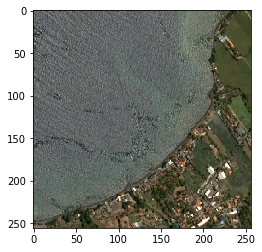

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


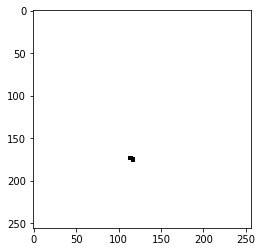

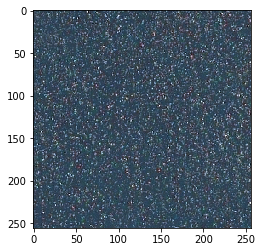

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


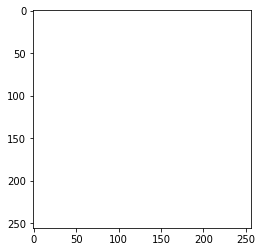

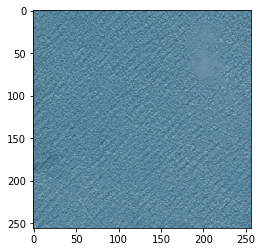

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


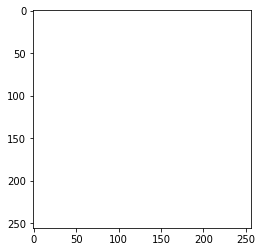

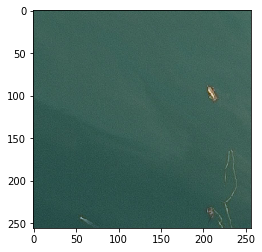

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


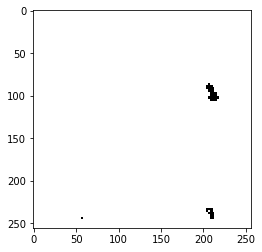

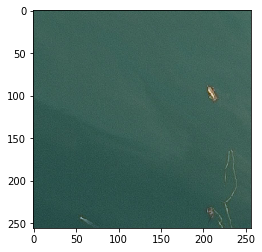

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


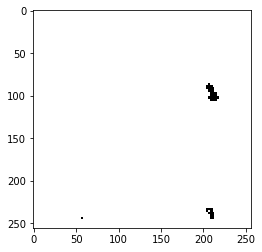

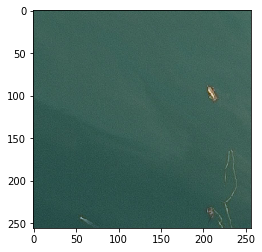

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


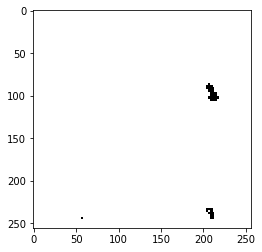

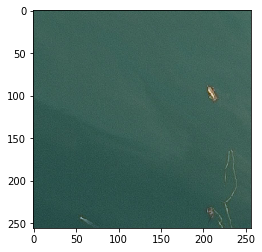

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


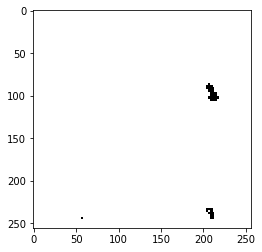

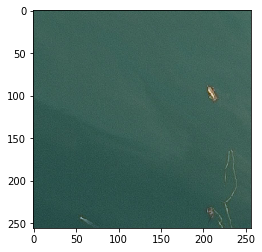

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


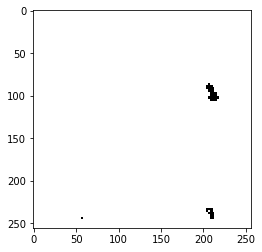

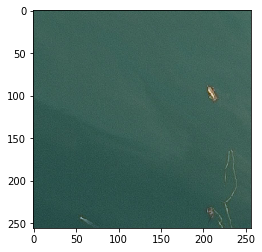

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


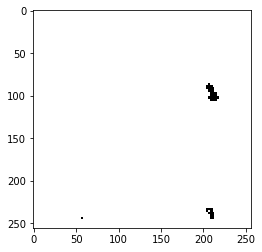

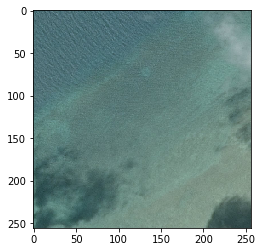

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


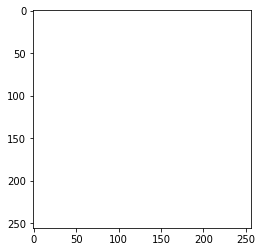

In [4]:
test = 10
d,l = makeData(test)
for i in range(test):
    plt.imshow(d[i])
    plt.show()
    plt.imshow(l[i]*255)
    plt.show()

Unet architecture for control, borrowed from https://github.com/zhixuhao/unet/blob/master/model.py

In [ ]:

def unet(pretrained_weights=None, input_size=(256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)
    
    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [36]:
un = unet()
un.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_26[0][0]                  
____________________________________________________________________________________________

C:\Users\juan\anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [37]:
data, labels = makeData(500)
un.fit(data, labels, batch_size=1, epochs=20)

Epoch 1/20
500/500 [==============================] - 136s 272ms/step - loss: 0.6509 - accuracy: 0.0031
Epoch 2/20
500/500 [==============================] - 134s 267ms/step - loss: 0.5959 - accuracy: 0.0031
Epoch 3/20
500/500 [==============================] - 134s 268ms/step - loss: 0.5347 - accuracy: 0.0031
Epoch 4/20
500/500 [==============================] - 134s 268ms/step - loss: 0.4698 - accuracy: 0.0031
Epoch 5/20
500/500 [==============================] - 141s 282ms/step - loss: 0.4024 - accuracy: 0.0031
Epoch 6/20
500/500 [==============================] - 143s 286ms/step - loss: 0.3319 - accuracy: 0.0031
Epoch 7/20
500/500 [==============================] - 144s 287ms/step - loss: 0.2544 - accuracy: 0.0041
Epoch 8/20
500/500 [==============================] - 144s 288ms/step - loss: 0.1304 - accuracy: 0.0047
Epoch 9/20
500/500 [==============================] - 144s 288ms/step - loss: 0.0736 - accuracy: 0.0047
Epoch 10/20
500/500 [==============================] - 144s 288m

In [45]:
# serialize model to JSON
model_json = un.to_json()

with open("un.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
un.save_weights("un.h5")

print("Saved model to disk")

Saved model to disk


In [7]:
# Static portion of GA network 
input_size = (256,256,3)
inputs = Input(input_size)
x = Conv2D(3, 1, activation = 'sigmoid')(inputs)

In [4]:
def MakeLayer(enn):
    """
    Returns a layer for use in the GA training process.
    
    """
    if enn is 0:
        return layers.Conv2D(filters=64,kernel_size=3, padding='same', activation='relu')
    elif enn is 1:
        return layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu')
    elif enn is 2:
        return layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu')
    elif enn is 3:
        return layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu')
    elif enn is 4:
        return layers.Conv2D(filters=1024,kernel_size=3, padding='same', activation='relu')
    elif enn is 5:
        return layers.MaxPool2D(pool_size=(2, 2))
    elif enn is 6:
        return layers.Dropout(.3)
    elif enn is 7:  # protective enum for selection schema
        return layers.concatenate([cat1,cat2], axis = 3)
    else:
        return layers.UpSampling2D(size = (2,2))

In [5]:
def skipCheck(layers_l, layers_ker, skip):
    """
    Checks for skip criteria, and if valid, writes global
    vars to be read.
    
    This function is using a 30/60 rule to make a skip layer.
    The first merging layer is positioned at 30% of the floor value
    of the subset of elements between the start and the end, and the
    second is 60% of the floor value of the same distance.
    e.g. [1,2,3,4,5,]
    cat1=1, cat2=3
    
    """
    global cat1,cat2

    ret = 2
    # if there are fewer than 3 layers, return 2
    if len(layers_l) < 3:
        ret = 2
    else:
        # Determine merging layers
        cat1 = math.floor(.3*(skip))
        cat2 = math.floor(.6*(skip))
        # Check for matching dimensions
        dims = [1,1,1,1,1,0.5,1,1,2]

        current_dim = 256
        d1 = 256  # merge layer 1
        d2 = 256  # merge layer 2
        d3 = 256  # layer before skip
        d4 = 256  # skip layer
        d5 = 256  # layer after skip

        for i in range(len(layers_l)):
            current_dim *= dims[layers_l[i]]
            if cat1 is i:
                d1 = current_dim
            if cat2 is i:
                d1 = current_dim    
            if skip-1 == i:
                d3 = current_dim                
            if skip is i:
                d4 = current_dim
                d5 = current_dim
            if skip+2 == current_dim:
                d5 = current_dim
        
        # merging layers have the same dimensions
        if d1 is not d2 :
            cat1 = None
            cat2 = None
            ret = 2
        # incoming and outgoing layers match dimensions to the skip layer
        elif (d3 is not d4) or (d4 is not d5):
            cat1 = None
            cat2 = None
            ret = 2   
        # otherwise, valid
        else:
            cat1 = layers_ker[cat1]
            cat2 = layers_ker[cat2]
            ret = 7
            
    return ret

In [6]:

def makeNetwork(layerz):
    """
    This is a factory method for the construction of a network given a list of layer enumerations.
    As mentioned in the paper, care must be taken to assigning skip layers as they have specific
    criteria to meet, so for each layer added, a skip check is performed. Once the list of enumerations
    is iterated through, this method will add maxpool or upscale layers as needed to fit the desired
    output dimensions. The final layer (2D convolutional layer using a sigmoid activation ) is added for
    the segmentation job, the model is compiled and returned. 
    """
    layers = layerz.copy()
    input_size = (256,256,3)
    inputs = Input(input_size)
    current_dim = 256
    x = []
    plc = 0
    lyr = layers.pop(0)
    
    if lyr is 7:  
        # perform skip check, will never be valid for n < 3 
        lyr = skipCheck(layerz, x, 0)
    
    x.append(MakeLayer(lyr)(inputs))
    
    # worst case O(n)
    plc += 1
    while layers:
        lyr = layers.pop(0)
        
        # perform skip check if raw layer enum is 7
        if lyr is 7: 
            lyr = skipCheck(layerz, x, plc)
            
            # valid skip layer already has an ouput no need to ref another
            if lyr is 7: 
                x.append(MakeLayer(lyr))
            
            # conv2d added, output required
            else:
                x.append(MakeLayer(lyr)(x[-1]))
        # all other processing
        else:
            x.append(MakeLayer(lyr)(x[-1]))
    
    # determing up or down sampling to fit output layer
    quo = x[-1].shape[1]/256
    if quo > 1 :
        # worst case O(4)
        for _ in range(int(quo) - 1):
            x.append(MakeLayer(5)(x[-1])) #top off with x number of maxPool layers
    else:
        # worst case O(4)
        for _ in range(int(1/quo/2)):
            x.append(MakeLayer(8)(x[-1])) #top off with x number of upsample layers
            
    #classfication layer needed for every network in test
    out = Conv2D(3, 1, activation = 'sigmoid')(x[-1])
    model = Model(inputs, out)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model
        

The produceOffspring function takes two lists (one for each winning network) designated between the first place winner and second place winner. The function will loop through a designated litter size (in this case, 4) creating a 4-individual network similar to the first place network, each allowing for the single insertion of one of the second place networks layers and another random mutation.

In [7]:
def produceOffspring(dom_layers, res_layers, litter_size):
    """
    Generate offspirng and randomly determine which recessive
    gene will be inserted and where, with a mutation occurring
    1 out of every 2 times.
    
    """
    # Randomly determine which recessive gene will be inserted and where.
    offspring = []
    print(res_layers)
    for _ in range(litter_size):
        # create a copy of the dominant layer
        child = dom_layers.copy()
        # get random seed for choosing a recessive layer
        er = int(np.random.random() * (len(res_layers)))
        # if 
        if er <= len(child) - 1:
            child[er]  = res_layers[er]
        else:
            child.append(res_layers[er])
            
        if np.random.random() > .5:
            # get a random number to represent a layer enumeration
            mut_type = int(np.random.random() * 9)
            child.append(mut_type)
        offspring.append(child)
        
    return offspring

The compete function takes a list of generations of which will compete to reproduce. The algorithm starts off by generating a random dataset of 100, followed by a loop iterating through each competing network, fitting them to the dataset provided, and keeping track of the final loss for each individual model which will be used to determine the two reproducing networks. To achieve in an O(n) fashion, a set of placekeepers were used to keep track of the two best scores at each iteration. This method only works if the two scores are kept in order which is why swap block is introduced at each iteration.

In [8]:
def compete(gens):
    
    d,l = makeData(100)
    w1,w2 =9999,9999 # winner 1 and 2
    g1,g2 = 9999,999 # generations of winner 1 and 2
    l1,l2 = 9999,9999 # winning loss 1 and 2
    
    for gen in gens:
        for mbr in pop_dict[gen]:
            # c is the contender
            # cl is the contender's loss
            c = mbr
            cl = pop_dict[gen][mbr]['model'].fit(d,l, batch_size=1, epochs=1)
            cl = cl.history['loss'][-1]
            
            # O(n) search for 2 best losses
            if cl < l1:
                l1 = cl
                w1 = c
                g1 = gen
            elif cl < l2:
                l2 = cl
                w2 = cl
                ge2 = gen
            
            # Processing only works if greatest value is replaced first
            if l1 < l2:
                t = w1
                tl = l1
                tg = g1
                
                w1 = w2
                l1 = l2
                g1 = g2
                
                w2 = t
                l2 = tl
                g2 = tg

    # Display winning networks' summary
    print('\n\n****************************************************************************************')
    print('Winner 1 with loss of ' + str(l2))
    pop_dict[gen][w2]['model'].summary()
    print('\n\n****************************************************************************************')
    print('Winner 2 with loss of ' + str(l1))
    pop_dict[gen][w1]['model'].summary()
    
    return pop_dict[g2][w2]['layers'], pop_dict[g1][w1]['layers']

For each competition iteration, a span was determined (i.e., the number of generations competing) followed by the actual competition where each model designated to compete is fitted.  In turn, the two winning networks will produce four offspring representing the next generation of competitors.

Due of the compute size of this task, iterations were done in three batches to prevent overloading the CPU and allowing the resources needed for training. 

Training Batch 1

In [9]:
num_of_gens = 3
global pop_dict
pop_dict = {}
# population 0
pop_dict[0] ={0:{'model':makeNetwork([0]),'layers':[0]}, 1:{'model':makeNetwork([2]),'layers':[2]},\
      2:{'model':makeNetwork([5]),'layers':[5]}, 3:{'model':makeNetwork([1]),'layers':[1]}}

     
for gen in range(num_of_gens):
    print('\n\n----------------Generation ' +str(gen)+'------------------')
    if gen < 3 :
        strt = 0
        stp = gen+1
    else:
        strt = gen-2
        stp = gen + 1
    
    span =[]
    for i in range(strt,stp):
        span.append(i)
    print(span)
    g1, g2 = compete(span)
    ofs = produceOffspring(g1,g2,4)
    print('ofs' +str(ofs))
    pop_dict[gen+1] ={0:{'model':makeNetwork(ofs[0]),'layers':ofs[0]}, 1:{'model':makeNetwork(ofs[1]),\
                                                                          'layers':ofs[1]},\
      2:{'model':makeNetwork(ofs[2]),'layers':ofs[2]}, 3:{'model':makeNetwork(ofs[3]),'layers':ofs[3]}}



----------------Generation 0------------------
[0]
Epoch 1/1
100/100 [==============================] - 6s 63ms/step - loss: 0.6537 - accuracy: 0.0019
Epoch 1/1
100/100 [==============================] - 15s 153ms/step - loss: 0.5823 - accuracy: 0.0025
Epoch 1/1
100/100 [==============================] - 1s 15ms/step - loss: 0.4958 - accuracy: 0.0025
Epoch 1/1
100/100 [==============================] - 8s 83ms/step - loss: 0.6077 - accuracy: 0.0024


****************************************************************************************
Winner 1 with loss of 0.4958261775970459
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 3)       0         
_________________________________________________________________


Batch 2

In [10]:
for gen in range(3,6):
    print('\n\n----------------Generation ' +str(gen)+'------------------')
    if gen < 3 :
        strt = 0
        stp = gen+1
    else:
        del pop_dict[gen-3] # needed to free up RAM
        strt = gen-2
        stp = gen + 1
    
    span =[]
    for i in range(strt,stp):
        span.append(i)
    print(span)
    g1, g2 = compete(span)
    ofs = produceOffspring(g1,g2,4)
    print('ofs' +str(ofs))
    pop_dict[gen+1] ={0:{'model':makeNetwork(ofs[0]),'layers':ofs[0]}, 1:{'model':makeNetwork(ofs[1]),\
                                                                          'layers':ofs[1]},\
      2:{'model':makeNetwork(ofs[2]),'layers':ofs[2]}, 3:{'model':makeNetwork(ofs[3]),'layers':ofs[3]}}



----------------Generation 3------------------
[1, 2, 3]
Epoch 1/1
100/100 [==============================] - 15s 151ms/step - loss: 0.2314 - accuracy: 0.0018
Epoch 1/1
100/100 [==============================] - 94s 944ms/step - loss: 0.0391 - accuracy: 0.0018
Epoch 1/1
100/100 [==============================] - 95s 949ms/step - loss: 0.0397 - accuracy: 0.0018
Epoch 1/1
100/100 [==============================] - 15s 154ms/step - loss: 0.2249 - accuracy: 0.0018
Epoch 1/1
100/100 [==============================] - 107s 1s/step - loss: 0.0495 - accuracy: 0.0018
Epoch 1/1
100/100 [==============================] - 95s 953ms/step - loss: 0.0470 - accuracy: 0.0018
Epoch 1/1
100/100 [==============================] - 95s 947ms/step - loss: 0.0507 - accuracy: 0.0018
Epoch 1/1
100/100 [==============================] - 170s 2s/step - loss: 0.0371 - accuracy: 0.0018
Epoch 1/1
100/100 [==============================] - 100s 998ms/step - loss: 0.3280 - accuracy: 0.0018
Epoch 1/1
100/100 [=======

Batch 3

In [11]:
for gen in range(6,9):
    print('\n\n----------------Generation ' +str(gen)+'------------------')
    if gen < 3 :
        strt = 0
        stp = gen+1
    else:
        del pop_dict[gen-3] # needed to free up RAM
        strt = gen-2
        stp = gen + 1
    
    span =[]
    for i in range(strt,stp):
        span.append(i)
    print(span)
    g1, g2 = compete(span)
    ofs = produceOffspring(g1,g2,4)
    print('ofs' +str(ofs))
    pop_dict[gen+1] ={0:{'model':makeNetwork(ofs[0]),'layers':ofs[0]}, 1:{'model':makeNetwork(ofs[1]),\
                                                                          'layers':ofs[1]},\
      2:{'model':makeNetwork(ofs[2]),'layers':ofs[2]}, 3:{'model':makeNetwork(ofs[3]),'layers':ofs[3]}}



----------------Generation 6------------------
[4, 5, 6]
Epoch 1/1
100/100 [==============================] - 154s 2s/step - loss: 0.0307 - accuracy: 0.0026
Epoch 1/1
100/100 [==============================] - 162s 2s/step - loss: 0.0316 - accuracy: 0.0026
Epoch 1/1
100/100 [==============================] - 576s 6s/step - loss: 0.0289 - accuracy: 0.0026
Epoch 1/1
100/100 [==============================] - 250s 2s/step - loss: 0.0323 - accuracy: 0.0026
Epoch 1/1
100/100 [==============================] - 320s 3s/step - loss: 0.0330 - accuracy: 0.0026
Epoch 1/1
100/100 [==============================] - 223s 2s/step - loss: 0.0357 - accuracy: 0.0026
Epoch 1/1
100/100 [==============================] - 370s 4s/step - loss: 0.0357 - accuracy: 0.0026
Epoch 1/1
100/100 [==============================] - 365s 4s/step - loss: 0.0339 - accuracy: 0.0026
Epoch 1/1
100/100 [==============================] - 968s 10s/step - loss: 0.1158 - accuracy: 0.0026
Epoch 1/1
100/100 [=====================

Epoch 1/1
100/100 [==============================] - 904s 9s/step - loss: 0.0278 - accuracy: 0.0020
Epoch 1/1
100/100 [==============================] - 357s 4s/step - loss: 0.0291 - accuracy: 0.0020
Epoch 1/1
100/100 [==============================] - 978s 10s/step - loss: 0.0291 - accuracy: 0.0020
Epoch 1/1
100/100 [==============================] - 375s 4s/step - loss: 0.0290 - accuracy: 0.0020
Epoch 1/1
100/100 [==============================] - 57s 566ms/step - loss: 0.3114 - accuracy: 0.0020
Epoch 1/1
100/100 [==============================] - 1041s 10s/step - loss: 0.0296 - accuracy: 0.0020
Epoch 1/1
100/100 [==============================] - 1225s 12s/step - loss: 0.0301 - accuracy: 0.0020
Epoch 1/1
100/100 [==============================] - 603s 6s/step - loss: 0.0319 - accuracy: 0.0020
Epoch 1/1
100/100 [==============================] - 326s 3s/step - loss: 0.1822 - accuracy: 0.0020
Epoch 1/1
100/100 [==============================] - 818s 8s/step - loss: 0.1199 - accuracy: 

The winning architecture is a series of convolution layers

In [24]:
pop_dict[8][0]['model'].summary()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 256, 256, 256)     7168      
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 256, 256, 128)     295040    
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 256, 256, 256)     295168    
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 256, 256, 128)     295040    
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 256, 256, 3)       387       
Total params: 892,803
Trainable params: 892,803
Non-trainable params: 0
____________________________________________________

Resulting dictionary 

In [22]:
pop_dict

{6: {0: {'layers': [2, 1, 4, 2],
   'model': <keras.engine.training.Model at 0x20c64bab828>},
  1: {'layers': [2, 1, 4],
   'model': <keras.engine.training.Model at 0x20c657b5518>},
  2: {'layers': [2, 1, 4, 8],
   'model': <keras.engine.training.Model at 0x20c60ff4278>},
  3: {'layers': [2, 1, 4],
   'model': <keras.engine.training.Model at 0x20c6100a518>}},
 7: {0: {'layers': [2, 1, 2, 4, 7],
   'model': <keras.engine.training.Model at 0x20c594fffd0>},
  1: {'layers': [2, 1, 2, 4, 1],
   'model': <keras.engine.training.Model at 0x20c594377f0>},
  2: {'layers': [2, 1, 2, 4, 2],
   'model': <keras.engine.training.Model at 0x20c5df7dcf8>},
  3: {'layers': [2, 1, 2, 4],
   'model': <keras.engine.training.Model at 0x20c679ee978>}},
 8: {0: {'layers': [2, 1, 2, 1],
   'model': <keras.engine.training.Model at 0x20c6632e1d0>},
  1: {'layers': [2, 1, 4, 1],
   'model': <keras.engine.training.Model at 0x20c68ddc2b0>},
  2: {'layers': [2, 1, 2, 1, 0],
   'model': <keras.engine.training.Model at

In [23]:
# serialize model to JSON
model_json = pop_dict[8][0]['model'].to_json()
with open("ga.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
pop_dict[8][0]['model'].save_weights("ga.h5")
print("Saved model to disk")

Saved model to disk


In [25]:
del pop_dict # free up some RAM

In [27]:
# load json and create model
json_file = open('ga.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
ga = model_from_json(loaded_model_json)
# load weights into new model
ga.load_weights("ga.h5")
print("Loaded model from disk")

Loaded model from disk


At this point in time the resulting GA network has been trained with a dataset of 100 images for 1 epoch. As an attempt to train the GA network similar ot UNet, we create a dataset of 400 images and it through the GA Network 20 times.

In [32]:
d, l = makeData(400)
ga.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
ga.fit(d,l,batch_size=1, epochs=20)

Epoch 1/20
400/400 [==============================] - 995s 2s/step - loss: 0.0280 - accuracy: 0.0018
Epoch 2/20
400/400 [==============================] - 1018s 3s/step - loss: 0.0261 - accuracy: 0.0018
Epoch 3/20
400/400 [==============================] - 1061s 3s/step - loss: 0.0258 - accuracy: 0.0018
Epoch 4/20
400/400 [==============================] - 977s 2s/step - loss: 0.0257 - accuracy: 0.0018
Epoch 5/20
400/400 [==============================] - 1058s 3s/step - loss: 0.0256 - accuracy: 0.0018
Epoch 6/20
400/400 [==============================] - 957s 2s/step - loss: 0.0256 - accuracy: 0.0018
Epoch 7/20
400/400 [==============================] - 902s 2s/step - loss: 0.0256 - accuracy: 0.0018
Epoch 8/20
400/400 [==============================] - 903s 2s/step - loss: 0.0256 - accuracy: 0.0018
Epoch 9/20
400/400 [==============================] - 907s 2s/step - loss: 0.0256 - accuracy: 0.0018
Epoch 10/20
400/400 [==============================] - 910s 2s/step - loss: 0.0256 - acc

In [33]:
# serialize model to JSON
model_json = ga.to_json()
with open("ga2.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
ga.save_weights("ga2.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# later...
 
# load json and create model
json_file = open('un.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
un = model_from_json(loaded_model_json)

# load weights into new model
un.load_weights("un.h5")
print("Loaded model from disk")

Given a model and an image file, generate predicted image and transform to match format of getImageMask() output: (768,768) image of 0s for ship and 1s for everything else.

In [424]:
def makePreds(img_loc, model):
    img = image.load_img(img_loc, target_size=(256, 256,3))
    img_tensor = image.img_to_array(img)
    img_tensor /= 255
    x =img_tensor.reshape((1,256,256,3))
    meow = model.predict(x)*255 
    meow[ meow > .95 ] =2
    meow[meow != 2] = 1
    meow[meow != 1] = 0
    im = Image.fromarray(meow[0].astype(np.uint8))#Least lossless method I could think of 
    im =im.resize((768,768))
    ret = image.img_to_array(im)
    # add channels together
    ret = ret[:,:,1] + ret[:,:,0] + ret[:,:,2]
    ret[ret < 2] = 1
    ret[ret != 1] = 0
    return ret.astype('uint8')

Raw image

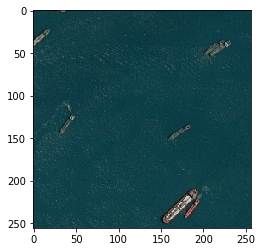

In [430]:
inspect = 'airbus-ship-detection\\train_v2\\'+'0aa565354.jpg'
img = image.load_img(inspect, target_size=(256, 256,3))
img_tensor = image.img_to_array(img)
img_tensor /= 255
x =img_tensor.reshape((1,256,256,3))
plt.imshow(x[0])

UNET predictions

570168

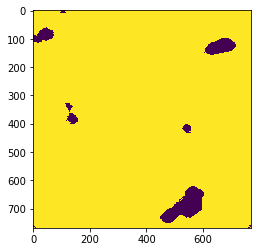

In [425]:
test = makePreds(inspect, un)
plt.imshow(test)
np.sum(test)  # sanity check

GA built network's predictions

572040

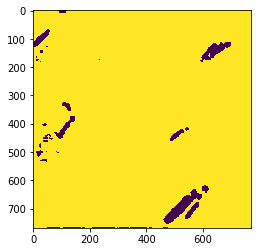

In [426]:
test = makePreds(inspect, ga)
plt.imshow(test)
np.sum(test)  # sanity check

Actual masked image

575182.0

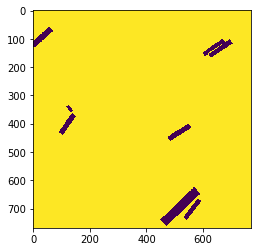

In [423]:
test = getImageMask('0aa565354.jpg')
plt.imshow(test) # needed to visualize
np.sum(test)

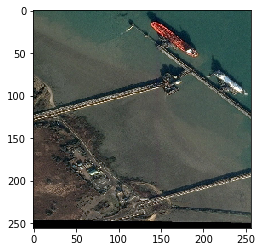

In [462]:
inspect = 'airbus-ship-detection\\train_v2\\'+'0c53e690b.jpg'
img = image.load_img(inspect, target_size=(256, 256,3))
img_tensor = image.img_to_array(img)
img_tensor /= 255
x =img_tensor.reshape((1,256,256,3))
plt.imshow(x[0])

507276

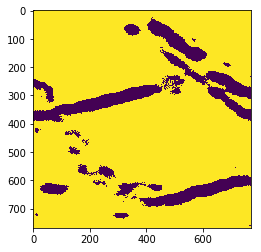

In [468]:
test = makePreds2(inspect, un)
plt.imshow(test)
np.sum(test)

491697

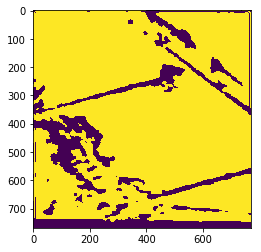

In [474]:
test = makePreds2(inspect, ga)
plt.imshow(test)
np.sum(test)

580332.0

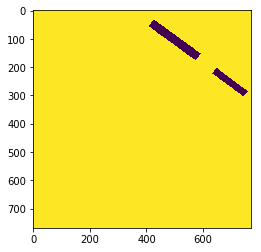

In [465]:
test = getImageMask('0c53e690b.jpg')
plt.imshow(test) # needed to visualize
np.sum(test)

A modified version of the makeData() function found previously in this notebook, modified to make and return a list of image ids.

In [ ]:
def makeData2(batch_size):
    data = []
    labels = []
    images = []
    count = 0
    root = 'airbus-ship-detection\\'
    d1 = 'train_v2\\'
    d2 = 'labels_\\'
    seed = int(np.random.random(1)*((total_images-1) - batch_size)) - 1
    f = csv.reader(open(root+'train_ship_segmentations_v2.csv'))
    for row in itertools.islice(f, seed, seed + batch_size):
        data = np.append(data, [np.array(img2array(root+d1+row[0]))])
        labels = np.append(labels, [np.array(img2array(root+d2+row[0]))])#revert to 0 and 1s
        images.append(row[0])
    data = data.reshape(batch_size,256,256,3)
    labels = labels.reshape(batch_size,256,256,3)
    return data,labels,images

Make batch of 1000 image, labels and image ids.

In [261]:
data, labels, images = makeData2(1000)

In [280]:
import random


def meanIoU(mask_true, mask_pred):
    """
    returns the mean Intersection over Union (IoU)
    for a given mask/image.
    """
    # the background counts as a class
    classVals = [0, 1]
    imgIoUs = []
    for i in classVals:
        class_true = (mask_true == i)
        class_pred = (mask_pred == i)
        # get the union of the class btwn true and pred
        areaUnion = np.count_nonzero(np.logical_or(class_true, class_pred)) + 1e-15 # prevent div by zero
        # get the overlap of the class btwn true and pred
        areaOverlap = np.count_nonzero(np.logical_and(class_true, class_pred))
        imgIoUs.append(areaOverlap/areaUnion)
    return np.mean(imgIoUs)
        
def meanDice(mask_true, mask_pred):
    """
    Returns the mean Dice/F1 score for given mask/image.
    This is very closely related to the IoU.
    
    """
    classVals = [0, 1]
    imgDice = []
    for i in classVals:
        class_true = (mask_true == i)
        class_pred = (mask_pred == i)
        # get the union of the class btwn true and pred
        areaUnion = np.count_nonzero(np.logical_or(class_true, class_pred))
        # get the overlap of the class btwn true and pred
        areaOverlap = np.count_nonzero(np.logical_and(class_true, class_pred))
        imgDice.append(2*areaOverlap/((len(class_true)**2)*2))
    
    return np.mean(imgDice)

def totalError(mask_true, mask_pred):
    """ 
    Returns the total error (% of FP + FN pixels in an image)
    
    """
    return np.count_nonzero(mask_true != mask_pred)/(768*768)

Loop through dataset and make predictions with UNET architecture  and collect metrics for each comparison.

In [414]:
un_ious = []
un_dices =[]
un_tes =  []
for i in range(len(data)):
    img = 'airbus-ship-detection\\train_v2\\'+images[i]
    mask_pred = makePreds(img, un)
    mask_true = getImageMask(images[i])
    un_ious.append(meanIoU(mask_true, mask_pred))
    un_dices.append(meanDice(mask_true, mask_pred))
    un_tes.append(totalError(mask_true, mask_pred))

In [416]:
print('Unet mean IOU score: ' + str(np.mean(un_ious)))
print('Unet mean DICE score: ' + str(np.mean(un_dices)))
print('Unet mean Total error: ' + str(np.mean(un_tes)))

Unet mean IOU score: 0.523885178367823
Unet mean DICE score: 0.49195838334825304
Unet mean Total error: 0.016083233303493927


Loop through dataset and make predictions with GA built architecture  and collect metrics for each comparison.

In [427]:
ga_ious = []
ga_dices =[]
ga_tes =  []
for i in range(len(data)):
    img = 'airbus-ship-detection\\train_v2\\'+images[i]
    mask_pred = makePreds(img, ga)
    mask_true = getImageMask(images[i])
    ga_ious.append(meanIoU(mask_true, mask_pred))
    ga_dices.append(meanDice(mask_true, mask_pred))
    ga_tes.append(totalError(mask_true, mask_pred))

In [428]:
print('GAnet mean IOU score: ' + str(np.mean(ga_ious)))
print('GAnet mean DICE score: ' + str(np.mean(ga_dices)))
print('GAnet mean Total error: ' + str(np.mean(ga_tes)))

GAnet mean IOU score: 0.2771795606084481
GAnet mean DICE score: 0.25605016326904295
GAnet mean Total error: 0.48789967346191404


In [473]:
def makePreds2(img_loc, model):
    """
    Modified function above to handle some of the inversion problems
    with the GA Network's predictions.
    
    """
    img = image.load_img(img_loc, target_size=(256, 256,3))
    img_tensor = image.img_to_array(img)
    img_tensor /= 255
    x = img_tensor.reshape((1,256,256,3))
    meow = model.predict(x)*255
    # set threshold for any pixel above a value of 0.95
    meow[meow > .95] = 2
    meow[meow != 2] = 1
    meow[meow != 1] = 0
    im = Image.fromarray(meow[0].astype(np.uint8))
    im =im.resize((768,768))
    ret = image.img_to_array(im)
    ret = ret[:,:,1] + ret[:,:,0] + ret[:,:,2]
    ret[ret < 2] = 1
    ret[ret != 1] = 0
    
    # Inverted prediction check, if image is more boat than ocean
    if np.sum(ret) < 768*768/2:
        ret[ret != 1] = 2
        ret[ret != 2] = 0
        ret[ret != 0] = 1
        
    return ret.astype('uint8')

In [475]:
"""
re-run prediction and score loop for UNET using updated makePreds method.

"""

un_ious = []
un_dices =[]
un_tes =  []
for i in range(len(data)):
    img = 'airbus-ship-detection\\train_v2\\'+images[i]
    mask_pred = makePreds2(img, un)
    mask_true = getImageMask(images[i])
    un_ious.append(meanIoU(mask_true, mask_pred))
    un_dices.append(meanDice(mask_true, mask_pred))
    un_tes.append(totalError(mask_true, mask_pred))

In [477]:
print('Unet mean IOU score: ' + str(np.mean(un_ious)))
print('Unet mean DICE score: ' + str(np.mean(un_dices)))
print('Unet mean Total error: ' + str(np.mean(un_tes)))

Unet mean IOU score: 0.523885178367823
Unet mean DICE score: 0.49195838334825304
Unet mean Total error: 0.016083233303493927


In [476]:
"""
re-run prediction and score loop for GAnet using updated makePreds method.

"""

ga_ious = []
ga_dices =[]
ga_tes =  []
for i in range(len(data)):
    img = 'airbus-ship-detection\\train_v2\\'+images[i]
    mask_pred = makePreds2(img, ga)
    mask_true = getImageMask(images[i])
    ga_ious.append(meanIoU(mask_true, mask_pred))
    ga_dices.append(meanDice(mask_true, mask_pred))
    ga_tes.append(totalError(mask_true, mask_pred))

Re-run the metrics done previously and plot some images of predictions to see improvements

In [478]:
print('GAnet mean IOU score: ' + str(np.mean(ga_ious)))
print('GAnet mean DICE score: ' + str(np.mean(ga_dices)))
print('GAnet mean Total error: ' + str(np.mean(ga_tes)))

GAnet mean IOU score: 0.48434803506631147
GAnet mean DICE score: 0.4623086098564995
GAnet mean Total error: 0.07538278028700086


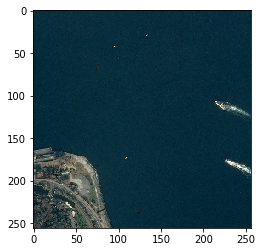

In [485]:
inspect = 'airbus-ship-detection\\train_v2\\'+'1aa5f647d.jpg'
img = image.load_img(inspect, target_size=(256, 256,3))
img_tensor = image.img_to_array(img)
img_tensor /= 255
x =img_tensor.reshape((1,256,256,3))
plt.imshow(x[0])

553617

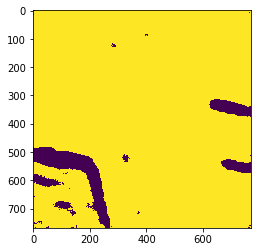

In [486]:
test = makePreds2(inspect, un)
plt.imshow(test)
np.sum(test)

536463

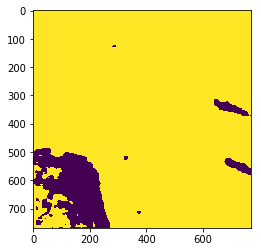

In [487]:
test = makePreds2(inspect, ga)
plt.imshow(test)
np.sum(test)

588347.0

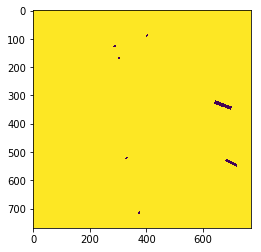

In [488]:
test = getImageMask('1aa5f647d.jpg')
plt.imshow(test) # needed to visualize
np.sum(test)